# Extract $\frac{1}{N_C}Tr(A_\perp^2)$ to compare with classical simulation

### Set up and configuration

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 1         
N = 128 
tau_sim = 0.25    
DTS = 8

# Derived parameters
a = L/N
E0 = N / L * hbarc
DT = 1.0 / DTS
maxt = int(tau_sim / a * DTS)
nplus = maxt//DTS

# Glasma fields
su_group = 'su3'
uv = 10.0
ir = 0.2
g2mu = 1.5


g = 2.0          		
mu = g2mu / g**2

ns = 50      

nevents = 100

In [2]:
import os

os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ['GAUGE_GROUP'] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

import curraun.su as su
import curraun.pi_fields as pi

/home2/carlos.lamas/condacurraun/lib/python3.10/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using CUDA
Using SU(3)
Using double precision


### Simulation

Define the simultion routine

In [3]:
from tqdm import tqdm

# Simulation rutine
def simulate():
    output = {}
    
    # Derived parameters
    a = L/N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    nplus = maxt//DTS
    
    # We create the object simulation
    s = core.Simulation(N, DT, g)

    # We initilize the Glasma fields
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)
    
    # We create objects to store the necessary fields
    # up = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    # Ay = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    Az = np.zeros((nplus, N*N, su.GROUP_ELEMENTS), dtype=su.GROUP_TYPE)
    
    # We create the object Glasma fields
    gf = pi.GlasmaFields(s)
    gf.init()
    
    # We simulate the event and store the fields when the spatial and temporal lattices match
    with tqdm(total=nplus) as pbar:    
        for t in range(maxt):
            
            # Evolve the Glasma fields
            core.evolve_leapfrog(s)
            
            # Store the fields
            if t % DTS == 0:
                
                xplus = t//DTS
                
                gf.compute_fields(xplus, a/hbarc)
                
                # up[xplus] = gf.up.copy()
                # Ay[xplus] = gf.ay.copy()
                Az[xplus] = gf.az.copy()
                
                pbar.update(1) 
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    # We write the transformed fields in a dictionary
    # output["up"] = up
    # output["Ay"] = Ay
    output["Az"] = Az
    
    return output

Run the simulation

In [6]:
import warnings
warnings.filterwarnings('ignore')

A_ev = np.zeros((nevents, nplus))

for n in range (nevents):
    
    print('Event %i' % n)
    output = simulate()
    
    # up = output['up']
    # Ay = output['Ay']
    Az = output['Az']
    A0 = Az[:, 0, :].reshape(maxt//DTS, 3, 3)
    A2 = np.array([A0[xplus] @ A0[xplus] for xplus in range(nplus)])
    
    A_ev[n] = np.array([np.trace(A2[xplus]) for xplus in range(nplus)]) / 3.0
    
# Average over events
A_avg = np.mean(A_ev, axis=0)
# Save the results
destination = os.path.join("..", "Jets in Glasma Results", "test_meeting", "archivo.txt")
np.savetxt(destination, A_avg)
    
    

Event 0


100%|██████████| 32/32 [00:02<00:00, 12.90it/s]


Event 1


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 2


100%|██████████| 32/32 [00:02<00:00, 13.05it/s]


Event 3


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 4


100%|██████████| 32/32 [00:02<00:00, 13.07it/s]


Event 5


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 6


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 7


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 8


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 9


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 10


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 11


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 12


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 13


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 14


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 15


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 16


100%|██████████| 32/32 [00:02<00:00, 13.07it/s]


Event 17


100%|██████████| 32/32 [00:02<00:00, 13.15it/s]


Event 18


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 19


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 20


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 21


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 22


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 23


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 24


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 25


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 26


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 27


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 28


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 29


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 30


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 31


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 32


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 33


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 34


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 35


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 36


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 37


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 38


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 39


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 40


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 41


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 42


100%|██████████| 32/32 [00:02<00:00, 13.07it/s]


Event 43


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 44


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 45


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 46


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 47


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 48


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 49


100%|██████████| 32/32 [00:02<00:00, 13.07it/s]


Event 50


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 51


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 52


100%|██████████| 32/32 [00:02<00:00, 13.07it/s]


Event 53


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 54


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 55


100%|██████████| 32/32 [00:02<00:00, 13.14it/s]


Event 56


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 57


100%|██████████| 32/32 [00:02<00:00, 13.07it/s]


Event 58


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 59


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 60


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 61


100%|██████████| 32/32 [00:02<00:00, 13.14it/s]


Event 62


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 63


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 64


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 65


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 66


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 67


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 68


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 69


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 70


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 71


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 72


100%|██████████| 32/32 [00:02<00:00, 13.16it/s]


Event 73


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 74


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 75


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 76


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 77


100%|██████████| 32/32 [00:02<00:00, 13.15it/s]


Event 78


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 79


100%|██████████| 32/32 [00:02<00:00, 13.07it/s]


Event 80


100%|██████████| 32/32 [00:02<00:00, 13.15it/s]


Event 81


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 82


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 83


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 84


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 85


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 86


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 87


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 88


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 89


100%|██████████| 32/32 [00:02<00:00, 13.13it/s]


Event 90


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 91


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 92


100%|██████████| 32/32 [00:02<00:00, 13.09it/s]


Event 93


100%|██████████| 32/32 [00:02<00:00, 13.08it/s]


Event 94


100%|██████████| 32/32 [00:02<00:00, 13.10it/s]


Event 95


100%|██████████| 32/32 [00:02<00:00, 13.06it/s]


Event 96


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


Event 97


100%|██████████| 32/32 [00:02<00:00, 13.05it/s]


Event 98


100%|██████████| 32/32 [00:02<00:00, 13.12it/s]


Event 99


100%|██████████| 32/32 [00:02<00:00, 13.11it/s]


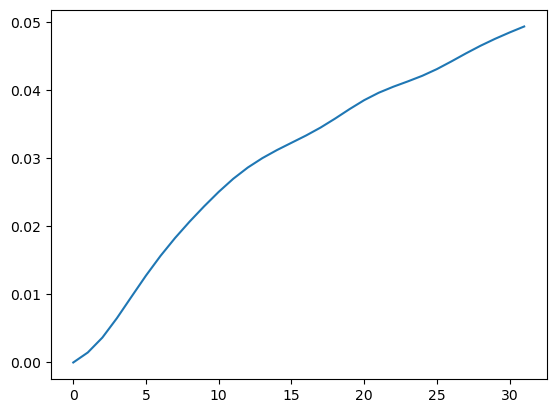

In [7]:
import matplotlib.pyplot as plt
plt.plot(A_avg)

In [6]:

A0 = Az[:, 0, :].reshape(maxt//DTS, 3, 3)

print(A0[10])

[[ 0.04077507-3.58365035e-19j  0.00204361+7.82658621e-02j
  -0.11133994-1.39391495e-01j]
 [ 0.00204361-7.82658621e-02j -0.04046856+5.38451201e-19j
  -0.01557048-5.82658318e-02j]
 [-0.11133994+1.39391495e-01j -0.01557048+5.82658318e-02j
  -0.00030651+2.22135819e-19j]]


In [7]:
A0_sum = [np.sum(A0[xplus]) for xplus in range(nplus)]
print(A0_sum)

[0j, (-0.02155556135663303+2.621658465502223e-21j), (-0.043472535062328115-3.4391803931313457e-18j), (-0.07460928543702301-7.22501211608654e-18j), (-0.10980615456541802-1.6527372593546601e-19j), (-0.1419145605946739-2.6066510437393107e-19j), (-0.16918003209486962+6.007894824342595e-19j), (-0.1952883098480829-7.224156936093091e-18j), (-0.22136825754485565+6.268143063471441e-17j), (-0.2417900200407651+7.692498893391973e-17j), (-0.24973361232329946+2.103881753030509e-17j), (-0.2438987641994793-4.183748478417981e-17j), (-0.22755600720762129-2.7806269853978687e-17j), (-0.20431806548715142-4.156736460453835e-17j), (-0.17727952778307574-1.4180848305682204e-17j), (-0.14931088980401946-1.0248116036261096e-18j), (-0.1221234163657994-1.4096242560384927e-16j), (-0.09648722129880252-1.9567141414097788e-16j), (-0.07404131223672578+8.80875411426191e-17j), (-0.05746562440438758+8.685501888953865e-17j), (-0.048032678815600596+5.643386125270004e-17j), (-0.04519640856244881-1.8839782509661282e-16j), (-0.

In [8]:
A2 = np.array([A0[xplus] @ A0[xplus] for xplus in range(nplus)])
    
print(A2[20])

[[ 0.06318335+6.42559776e-19j  0.00411613-5.59797396e-03j
   0.00246467-1.53486140e-02j]
 [ 0.00411613+5.59797396e-03j  0.02647703-2.50436044e-19j
  -0.02897577+4.63169358e-03j]
 [ 0.00246467+1.53486140e-02j -0.02897577-4.63169358e-03j
   0.04396901+1.33104402e-18j]]


In [26]:
A2_sum = [np.sum(A2[xplus]) for xplus in range(nplus)]
print(A2_sum)

[0j, (0.027237815133748428+3.167553259373315e-20j), (0.06960376483370326-3.990486265961066e-18j), (0.12245605284451852-1.528100477036554e-17j), (0.1838793218204445+1.674203957465347e-17j), (0.29738101208828027+3.2543109413673937e-18j), (0.5080655916493294-6.530703842847216e-18j), (0.8369257980287106+7.3181020284948e-17j), (1.2969192895444124+5.778844749829883e-17j), (1.877487255216643+1.1812191755444366e-16j), (2.527898860333009+8.459294800684485e-17j), (3.179360718570505+3.5792041749914707e-16j), (3.773504076459389+4.645909915326501e-16j), (4.273656146946749+2.2273537832053287e-16j), (4.656555703082229+1.9131515085075324e-16j), (4.898801013000783-2.1944599153312043e-16j), (5.009904568940085-3.356137438954745e-16j), (5.074813505180552+2.540052799566542e-16j), (5.214118827924798-3.652846929108109e-16j), (5.508602346122356+5.170328057678737e-16j), (5.972424999469227-3.37603621095871e-16j), (6.569567224961729-2.133701543861545e-15j), (7.23117926941625-1.4860862802214446e-15j), (7.84697705

In [1]:
A_av = [1/3*np.trace(A2[xplus].real) for xplus in range(nplus)]
print(A_av)

NameError: name 'nplus' is not defined

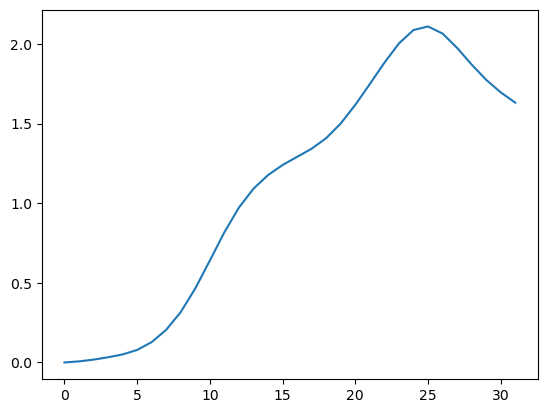

In [29]:
import matplotlib.pyplot as plt
plt.plot(A_av)

Average over events

In [ ]:
pkin = np.mean(A_ev, axis=0)

In [17]:
print(pkin)

[0.         0.00152141 0.00378283 0.00666718 0.0096298  0.01229677
 0.01460419 0.01669806 0.01871317 0.02065594 0.02244242 0.02399473
 0.0253047  0.02643704 0.02749379 0.02857647 0.0297455  0.03098011
 0.03219596 0.0333223  0.03435465 0.03533789 0.0363459  0.0374678
 0.03874955 0.04015256 0.04159394 0.0430097  0.04436198 0.04562129
 0.04677321 0.04783035]


### Plot the results

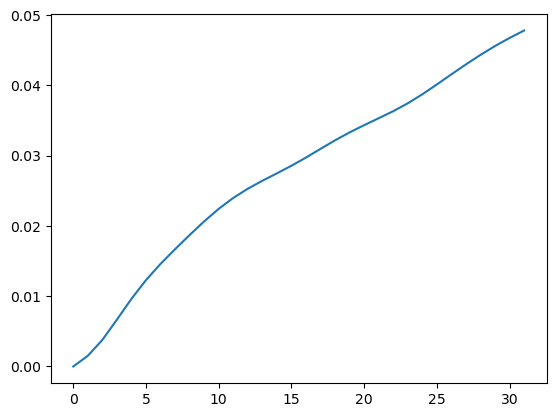

In [18]:
import matplotlib.pyplot as plt

plt.plot(pkin)

We save to file

### Another way

In [12]:
A0 = Az[:, 0, :].reshape(maxt//DTS, 3, 3)

In [23]:
A0c0 = np.array([A0[xplus, 0, 0]**2 for xplus in range(nplus)])
A0c1 = np.array([A0[xplus, 1, 1]**2 for xplus in range(nplus)])
A0c2 = np.array([A0[xplus, 2, 2]**2 for xplus in range(nplus)])

In [24]:
A_av = [1/3 * (A0c0[xplus] + A0c1[xplus] + A0c2[xplus]) for xplus in range(nplus)]

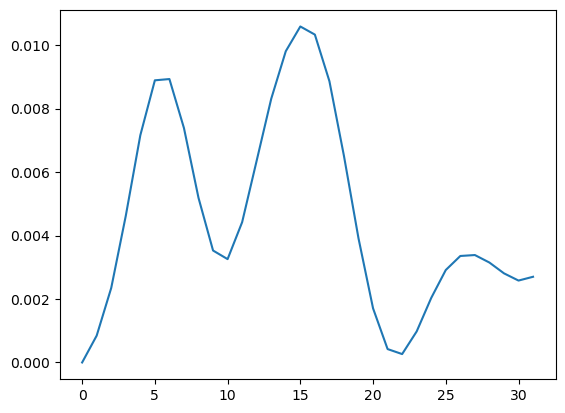

In [25]:
plt.plot(A_av)